In [1]:
import matplotlib.pyplot as plt
import numpy as np
import uproot
import tensorflow as tf
import zfit

/home/hdhoang2001/miniconda3/envs/tesla/lib/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/home/hdhoang2001/miniconda3/envs/tesla/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.5 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the

In [2]:
data = uproot.open("filtered_data/mass.root:CandidateTree").arrays(library="np")["candidate_vMass"]

In [3]:
def parameter(name, value, lower=None, upper=None):
    try:
        return zfit.Parameter(name, value, lower, upper)
    except zfit.exception.NameAlreadyTakenError:
        del zfit.Parameter._existing_params[name]
        return zfit.Parameter(name, value, lower, upper)

In [4]:
mass = zfit.Space('candidate_vMass', limits=(5.33, 5.4))

mu = parameter("mu", 5.37, 5.33, 5.4)
sigma = parameter("sigma", 0.01, 0.001, 0.2)
signal = zfit.pdf.Gauss(obs=mass, mu=mu, sigma=sigma)

a0 = parameter("a0", 0.5, 0.0, 1.0)
a1 = parameter("a1", -0.3, -0.5, 1.0)
bkg = zfit.pdf.Chebyshev(obs=mass, coeffs=[a0, a1])

fraction = parameter("fraction", 0.5, 0, 1)

model = zfit.pdf.SumPDF([signal, bkg], fraction)

In [9]:
nll = zfit.loss.UnbinnedNLL(model=model, data=zfit.Data.from_numpy('candidate_vMass', data))  # loss

minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

print(minimum)

/home/hdhoang2001/miniconda3/envs/tesla/lib/python3.9/site-packages/zfit/core/loss.py:205: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['inconsistent_fitrange']` = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
PDFs [<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, fraction]] as well as `data` [<zfit.core.data.Data object at 0x7f003159f610>] have different ranges [(<zfit Space obs=('candidate_vMass',), axes=(0,), limits=(array([[5.33]]), array([[5.4]]))>, <zfit Space obs=('candidate_vMass',), axes=(0,), limits=None>)] they are defined in. The data range will cut the data while the norm range defines the normalization.
  warn_advanced_feature(f"PDFs {non_consistent['model']} as "


FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, fraction]] data=[<zfit.core.data.Data object at 0x7f003159f610>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.9e-06 │ -7740       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value    at limit
--------  --------  ----------
fraction    0.4156       False
mu           5.367       False
sigma     0.008588       False
a0         0.02812       False
a1         -0.3602       False


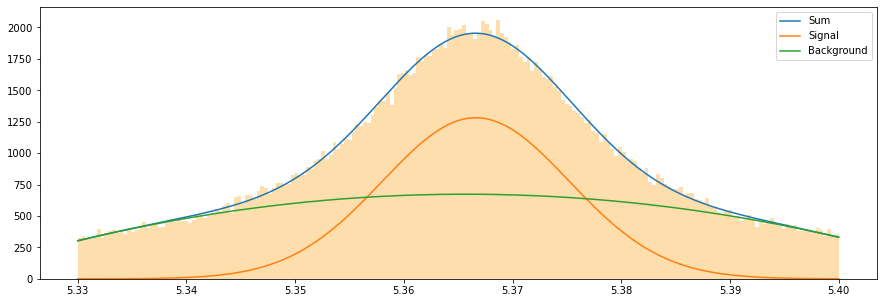

In [10]:
mass_range = (5.33, 5.4)
n_bins = 200

plt.figure(figsize=(15, 5))
plt.hist(data, bins=n_bins, color="navajowhite")

mass = np.linspace(*mass_range, num=1000)

pdf = zfit.run(model.pdf(mass))
gauss = (signal.pdf(mass) * fraction).numpy()
chebyshev = (bkg.pdf(mass) * (1 - fraction)).numpy()

scale = len(data) / n_bins * (mass_range[1] - mass_range[0])

plt.plot(mass, pdf * scale, label="Sum")
plt.plot(mass, gauss * scale, label="Signal")
plt.plot(mass, chebyshev * scale, label="Background")
plt.legend()